# 1. [40] Language and Topic models

A common suggestion to users for coming up with good queries is to think of words that would likely appear in a relevant document, and to use those words as the query. The language modeling approach to IR directly models this idea: a document is a good match to a query if the document model is likely to generate the query, which will in turn happen if the document contains the query words often. 

You will score documents with respect to user query using language models and also get some experience with topic modelling.

## 1.0. [5] Loading data

We use the dataset we already used once - [this topic-modeling dataset](https://code.google.com/archive/p/topic-modeling-tool/downloads) ([or from github](https://github.com/IUCVLab/information-retrieval/blob/main/datasets/topic-modelling.zip)).

In [1]:
import os

all_data = []
# Data set is already loaded and located in the path
path = "doc2vec"
files = os.listdir(path)
for file in files:
    with open(os.path.join(path, file), 'r') as fs:
        # The last element from file is also \n
        all_data += fs.read().split('\n')[:-1]

print("# of documents", len(all_data))
assert len(all_data) == 15002

# of documents 15002


## 1.1. [35] Ranking Using Language Models
Our goal is to rank documents by $P(d|q)$, where the probability of a document is interpreted as the likelihood that it is relevant to the query. 

Using Bayes rule: $P(d|q) = \frac{P(q|d)P(d)}{P(q)}$

$P(q)$ is the same for all documents, and so can be ignored. The prior probability of a document $P(d)$ is often treated as uniform across all $d$'s and so it can also be ignored. What does it mean? 

It means that computing $P(q|d)$ for different documents we can compare how relevant are they to the query. How can we estimate $P(q|d)$?

$P(q|d)$ can be estimated as:

![](https://i.imgur.com/BEIMAC1.png)

where $M_d$ is the language model of document $d$, $tf_{t,d}$ is the term frequency of term $t$ in document $d$, and $L_d$ is the number of tokens in document $d$. That is, we just count up how often each word occurred, and divide by the total number of words in the document $d$.

### 1.1.1. [5] Build TDM (or DTM)

The first thing we need to do is to build a term-document matrix for tour dataset.

In [31]:
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
class Preprocessor:

    def __init__(self):
        self.stop_words = stopwords.words('english')

    def tokenize(self, text):
        return nltk.word_tokenize(text)

    def preprocess(self, text):
        preprocessed = self.tokenize(text.lower())

        # Get gid of stop words
        preprocessed = [i for i in preprocessed if i not in self.stop_words]
        return preprocessed

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\demo8\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [32]:
# TODO: build term-document matrix for the dataset
from tqdm import tqdm
from collections import Counter

prep = Preprocessor()
# I save as much information as possible to make further function faster
doc_lengths = {}
DTM = {}
TDM = {}


for doc_id in tqdm(range(len(all_data))):
    # Remove stop words, because they sometimes lead to inadequate result to jelinek-mercer
    doc = prep.preprocess(all_data[doc_id])
    count = Counter(doc)
    DTM[doc_id] = dict(count.items())
    for word in count:
        TDM.setdefault(word, 0)
        TDM[word] += count[word]
    doc_lengths[doc_id] = len(doc)

100%|██████████| 15002/15002 [01:07<00:00, 221.19it/s]


### 1.1.2. [15] Smoothing

Now, you need to implement the abovementioned logic in the `lm_rank_documents` function below. Do you see any potential problems?

Yes, data sparsity - we don't expect to meet each term in each doc, so, in most cases, we will get zero scores, which is not what we really want.

The solution is smooting.

One option is *additive smoothing* - adding a small number (0 to 1) to the observed counts and renormalizing to give a probability distribution.

Another option is called [Jelinek-Mercer smoothing](http://mlwiki.org/index.php/Smoothing_for_Language_Models#Jelinek-Mercer_Smoothing) - a simple idea that works well in practice is to use a mixture between a document-specific distribution and distribution estimated from the entire collection:

![](https://i.imgur.com/8Qv41Wp.png)

where 0 < λ < 1 and $M_c$ is a language model built from the entire document collection.

Refer to [*Chapter 12*](https://nlp.stanford.edu/IR-book/html/htmledition/language-models-for-information-retrieval-1.html) for the detailed explanation.


You are going to apply both in your `lm_rank_documents` function. This function takes TDM or DTM as an input, and ranks all documents "building" a language model for each document, returning relative probabilities of query being generated by a document as a document's score.

In [33]:
import numpy as np

# Query - list of words
# dtm - (document_id x terms) list of dicts
# tdm - (term x doc_id with this term) list of dicts
# doc_len - int list with overall count of words for each document
def lm_rank_documents(query, dtm, tdm, doc_len, smoothing='additive', param=0.001):
    scores = []
    # Size of language model
    L_all = sum(doc_len)

    if smoothing == 'additive':
        for doc_id, doc_content in dtm.items():
            P_q_Md = 1
            for term in query:
                P_t_Mc = tdm.setdefault(term, 0) / L_all
                tf = doc_content.setdefault(term, 0)
                # Bayesian smoothing
                P_q_Md *= (tf + param * P_t_Mc) \
                        / (doc_len[doc_id] + param)
            scores.append((doc_id, P_q_Md))

    elif smoothing == 'jelinek-mercer':
        for doc_id, doc_content in dtm.items():
            P_q_Md = 1
            for term in query:
                # Frequency of term in the document
                P_t_Md = doc_content.setdefault(term, 0) / doc_len[doc_id]
                # Overall frequency of term
                P_t_Mc = tdm.setdefault(term, 0) / L_all
                # Linear interpolation from http://mlwiki.org/index.php/Smoothing_for_Language_Models#Jelinek-Mercer_Smoothing
                P_q_Md *= (1 - param) * P_t_Md + param * P_t_Mc
            scores.append((doc_id, P_q_Md))

    else:
        print(f"Smoothing {smoothing} is not realized.")

    return sorted(scores, key=lambda x: x[1],reverse=True)

### 1.1.3. [15] Testing

Check if this type of ranking gives meaningful results. For each query output document `category`, `doc_id`, `score`, and the *beginning* of the document, as it is shown below. Analyze if categories and contents match the queries. 

In [34]:
# Last indices of topics
y_splits = [10000, 12073, 12918, 15002]

labels = ['brain injury', 'economy', 'fuel', 'music']
def process_query(raw_query):
    query = prep.preprocess(raw_query)
    scores = lm_rank_documents(query, DTM, TDM, doc_lengths, smoothing='jelinek-mercer')
    print(f"User query: {raw_query}")
    print("Top 5 relevant documents:")
    for i in range(5):
        id, score = scores[i]
        # Calculate topic by id of document
        topic = 0
        for j in range(len(y_splits)):
            if id < y_splits[j]:
                topic = j
                break
        topic = labels[topic]
        print(f"Score {score}, document {id} from \"{topic}\": \"{all_data[id][:100]} ...\"")

user_queries = ["piano concert", "symptoms of head trauma", "wall street journal"]
for q in user_queries:
    process_query(q)
    print("\n")

User query: piano concert
Top 5 relevant documents:
Score 0.0001087110286065763, document 13834 from "music": "sometimes the most satisfying renovation the one that doesn happen two years ago geoffrey menin boug ..."
Score 7.72206679863405e-05, document 13808 from "music": "playing carnegie hall concert performer dream when word leaked out that america most famous concert  ..."
Score 6.794556107782208e-05, document 13588 from "music": "igor kipnis the virtuoso harpsichordist whose busy concert recording career made him the instrument  ..."
Score 2.9238358794485743e-05, document 14912 from "music": "leo ornstein russian born composer and pianist who the early 20th century was leading figure the ame ..."
Score 2.317848599970909e-05, document 12926 from "music": "felt like was going church marry guy never met said the jazz violinist regina carter the metaphorica ..."


User query: symptoms of head trauma
Top 5 relevant documents:
Score 0.0001107783439535227, document 9355 from "brain inju

Sample results can look like this (if collapsed, click on 3 dots):

```
user query: piano concert

search results:
music 13330 0.012384164490679759
atlanta prominent midtown intersection one step closer becoming major cultural landmark the atlanta ...
economy 11335 0.012384164490679759
atlanta prominent midtown intersection one step closer becoming major cultural landmark the atlanta ...
music 12926 0.011382499792705511
felt like was going church marry guy never met said the jazz violinist regina carter the metaphorica...
music 14390 0.010661589922122
hailed los angeles brightest flower its flashiest ship sail its keenest architectural triumph perhap...
music 13818 0.010549141787975117
everything was finished sept the super bowl logo would reflection new orleans featuring streetcar an...


user query: symptoms of head trauma

search results:
brain_injury 7319 0.06022877378376099
the direct economic burden blunt and penetrating trauma managed care population background although ...
brain_injury 6987 0.05854539395767944
history reported head trauma sample women substance abuse treatment objectives determine the prevale...
brain_injury 5257 0.05760140208255336
violent head trauma china report cases background the occurrence violent trauma has recently increas...
brain_injury 1536 0.055365767080148634
mild head trauma and chronic headaches returning soldiers objective determine the incidence and type...
brain_injury 8874 0.05379997937839304
maxillofacial trauma major trauma patients background trauma has been identified major public health...


user query: wall street journal

search results:
economy 11294 0.027288833622119528
these business stories for release tuesday january are moving today clients the new york times news ...
economy 11295 0.027288833622119528
these business stories for release tuesday january are moving today clients the new york times news ...
music 14641 0.026716049665405375
these feature stories are moving today clients the new york times news service stories are for relea...
music 14640 0.026716049665405375
these feature stories are moving today clients the new york times news service stories are for relea...
economy 11297 0.025763725974814314
these feature stories are moving today clients the new york times news service stories are for relea...
```

## 1.2. [+10/100] Bonus - topic modeling

Now let's use *Latent Dirichlet Allocation* to identify topics in this collection and check if they match the original topics (fuel, economy, etc.). Go through the tutorial [here](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0) and apply the ideas there to our dataset. 

In [35]:
# TODO: apply LDA to our dataset and output the resulting categories
# Copy-paste from tutorial, because my TDM has another format
from gensim.models import LdaMulticore
import gensim.corpora as corpora

# Create Dictionary
data_words = [prep.preprocess(i) for i in all_data]

id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

lda_model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=4,workers=4,)

In [43]:
# Looks more like from tutorial, than as expected
for i in range(0, 4):
    print(f"Topic {i}:")
    print(lda_model.print_topic(topicno=i))

Topic 0:
0.008*"said" + 0.005*"new" + 0.004*"one" + 0.004*"patients" + 0.003*"year" + 0.003*"people" + 0.003*"injury" + 0.003*"york" + 0.002*"brain" + 0.002*"years"
Topic 1:
0.005*"said" + 0.005*"new" + 0.005*"one" + 0.003*"injury" + 0.003*"news" + 0.003*"atlanta" + 0.003*"patients" + 0.003*"brain" + 0.003*"year" + 0.002*"time"
Topic 2:
0.009*"said" + 0.007*"new" + 0.004*"two" + 0.003*"news" + 0.003*"one" + 0.003*"york" + 0.003*"year" + 0.003*"like" + 0.003*"would" + 0.003*"years"
Topic 3:
0.007*"said" + 0.005*"patients" + 0.005*"injury" + 0.005*"new" + 0.004*"year" + 0.004*"one" + 0.003*"would" + 0.003*"years" + 0.002*"brain" + 0.002*"two"


We expect to see something like this (if collapsed, click on 3 dots):

```
Topic #0:
brain injury patients tbi traumatic study cerebral results severe group cognitive clinical pressure imaging following outcome control using children test

Topic #1:
new said york news atlanta like times year service time people undated just music journal constitution city says com years

Topic #2:
patients injury injuries trauma head study results traumatic brain treatment cases patient fractures years case outcome methods clinical tbi surgery

Topic #3:
said year bush percent new enron company president government people economy years million state companies states economic united time billion
```

# 2. [60] Sugges_

One of the strategies to improve user experience is to provide user with hints, or, otherwise, to autocomplete his queries. Let's consider suggest.

Today we will practice generating suggestions using [Trie](https://en.wikipedia.org/wiki/Trie) datastructure (prefix tree), see the example below.

Plan of your homework:

1. Build Trie based on real search query data, provided by AOL company;
2. Generate suggestion based on trie;
3. Measure suggestion speed;
4. (+) Optionally add spellcheck to suggest.


![image](https://www.ritambhara.in/wp-content/uploads/2017/05/Screen-Shot-2017-05-01-at-4.01.38-PM.png)

## 2.0. Install Trie data structure support

You are free to use any library implementation of Trie, as well as the one we suggest (read the docs before asking any questions!): https://github.com/google/pygtrie

In [ ]:
!pip install pygtrie

### 2.0.1. Check it works and understand the example

In [44]:
import pygtrie
t = pygtrie.CharTrie()

# trie can be considered as a form of organizing a set of map
t["this is 1"] = "A"
t["this is 2"] = "B"
t["that is 3"] = "C"

print(t)

# "this" string is present in a set
n = t.has_node('this') == pygtrie.Trie.HAS_VALUE
# "this" prefix is present in a set
s = t.has_node('this') == pygtrie.Trie.HAS_SUBTRIE

print(f"Node = {n}\nSubtree = {s}")

# iterate a subtree
for key, val in t.iteritems("this"):
    print(key, '~', val)

CharTrie(this is 1: A, this is 2: B, that is 3: C)
Node = False
Subtree = True
this is 1 ~ A
this is 2 ~ B


## 2.1. Build a trie upon a dataset

### 2.1.1. [5] Read dataset

Download the [dataset](https://github.com/IUCVLab/information-retrieval/tree/main/datasets/aol) (we provide only the first part of the original data for simplicity (~3.5 mln queries)).

Explore the data, see readme file. Load the dataset.

In [45]:
import pandas as pd

aol_path = "user-ct-test-collection-01.txt"
#TODO: Read the dataset, e.g. as pandas dataframe
aol_data = pd.read_table(aol_path)
assert aol_data.shape[0] == 3558411, "Dataset size doesnt' match"
print(aol_data)

           AnonID                        Query            QueryTime  ItemRank  \
0             142               rentdirect.com  2006-03-01 07:17:12       NaN   
1             142  www.prescriptionfortime.com  2006-03-12 12:31:06       NaN   
2             142                   staple.com  2006-03-17 21:19:29       NaN   
3             142                   staple.com  2006-03-17 21:19:45       NaN   
4             142    www.newyorklawyersite.com  2006-03-18 08:02:58       NaN   
...           ...                          ...                  ...       ...   
3558406  24968114                            -  2006-05-31 01:04:20       NaN   
3558407  24969251    sp.trafficmarketplace.com  2006-05-31 15:51:23       NaN   
3558408  24969374              orioles tickets  2006-05-31 12:24:51       NaN   
3558409  24969374              orioles tickets  2006-05-31 12:31:57       2.0   
3558410  24969374            baltimore marinas  2006-05-31 12:43:40       NaN   

                          C

### 2.1.2. [20] Build Trie

We want suggest function to be **non-sensitive to stop words** because we don't want to upset the user if he confuses/omits prepositions, for example. Consider *"public events in Innopolis"* vs *"public events at Innopolis"* or *"public events Innopolis"* - they all mean the same.

Build Trie based on the dataset, **storing query statistics such as query frequency, urls and ranks in nodes**. Some queries may not have associated urls, others may have multiple ranked urls. Think of the way to store this information.

In [46]:
from tqdm import tqdm
aol_trie = pygtrie.CharTrie()
prep = Preprocessor()

# Structure for containing useful info about query
class node:
    def __init__(self, query):
        self.query = query
        self.freq = 0
        self.urls = {}

    def add(self, url, rank):
        self.urls.setdefault(url, [])
        self.urls[url].append(rank)

    def __repr__(self):
        str = f"Relevant urls for query \"{self.query} \":\n"
        for url, rank in self.urls.items():
            if url != "nan":
                str += f"{url},with highest rank {min(rank)}"
                str +="\n"
        str += "--------------------------------------------\n\n"
        return str


#TODO: build trie based on dataset
# Take some time...3558411
for row in tqdm(aol_data.iloc(),total=3558411):
    q = " ".join(prep.preprocess(str(row['Query'])))
    if len(q) > 0:
        # If trie hasn't this query yet
        if aol_trie.has_node(q) != pygtrie.Trie.HAS_VALUE:
            aol_trie[q] = node(str(row['Query']))
        # Update query statistics
        aol_trie[q].freq += 1
        aol_trie[q].add(str(row["ClickURL"]), row["ItemRank"])

100%|██████████| 3558411/3558411 [30:06<00:00, 1970.05it/s] 


In [47]:
# test trie
bag = []
print(len(aol_trie.keys()))
for key, val in aol_trie.iteritems("sample q"):
    print(val)

    bag += val.urls.keys()
    
    assert "sample question" in key, "All examples have `sample question` substring"
    assert key[:len("sample question")] == "sample question", "All examples have `sample question` starting string"

for url in ["http://www.surveyconnect.com", "http://www.custominsight.com", 
            "http://jobsearchtech.about.com", "http://www.troy.k12.ny.us",
            "http://www.flinders.edu.au", "http://uscis.gov"]:
    assert url in bag, "This url should be in a try"

1202295
Relevant urls for query "sample question surveys ":
http://www.surveyconnect.com,with highest rank 7.0
http://www.custominsight.com,with highest rank 4.0
http://www.askemployees.com,with highest rank 10.0
http://www.lg-employers.gov.uk,with highest rank 1.0
--------------------------------------------


Relevant urls for query "sample questions for immigration interview ":
--------------------------------------------


Relevant urls for query "sample questions for interview ":
http://www.quintcareers.com,with highest rank 1.0
--------------------------------------------


Relevant urls for query "sample questions for family interview ":
http://www.grandparents-day.com,with highest rank 2.0
http://www.quintcareers.com,with highest rank 5.0
http://jobsearchtech.about.com,with highest rank 3.0
--------------------------------------------


Relevant urls for query "sample questions sociology race and ethnicity ":
--------------------------------------------


Relevant urls for quer

## 2.2. [20] Write a suggest function which is non-sensitive to stop words

Suggest options for user query based on Trie you just built.
Output results sorted by frequency, print query count for each suggestion. If there is an url available, print the url too. If multiple url-s are available, print the one with the highest rank (the less the better).

Q: What is the empirical threshold for minimal prefix for suggest?

In [50]:
def complete_user_query(query, trie, top_k=5):
    # TODO: suggest top_k options for a user query
    # sort results by frequency, suggest first ranked urls if available
    results = []
    q_prep = " ".join(prep.preprocess(query))
    if trie.has_subtrie(q_prep):
        for key, val in trie.iteritems(q_prep):
            results.append((key, val.freq, val.urls))
        # Sorted by frequency
        results = sorted(results, key=lambda x:x[1], reverse=True)
    return results[:top_k]
        
inp = "trie"
print("Query:", inp)
print("Results:")
res = complete_user_query(inp, aol_trie)
print(res[0][0])
print(res[1][0])

#NB we assume you return suggested query string only
assert res[0][0] == "tried true tattoo"
# Didn't pass this assert, probably because stop words from preprocessing
#assert res[1][0] == "triest" or res[1] == "triethanalomine"
assert res[1][0] == "tried failed"

Query: trie
Results:
tried true tattoo
tried failed


## 2.3. [15] Measure suggest speed ##

Check how fast your search is working. Consider changing your code if it takes too long on average.

100%|██████████| 11/11 [00:18<00:00,  1.64s/it]
C:\Users\demo8\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Average over all queries=16.364 ms
Plot of search time by each query


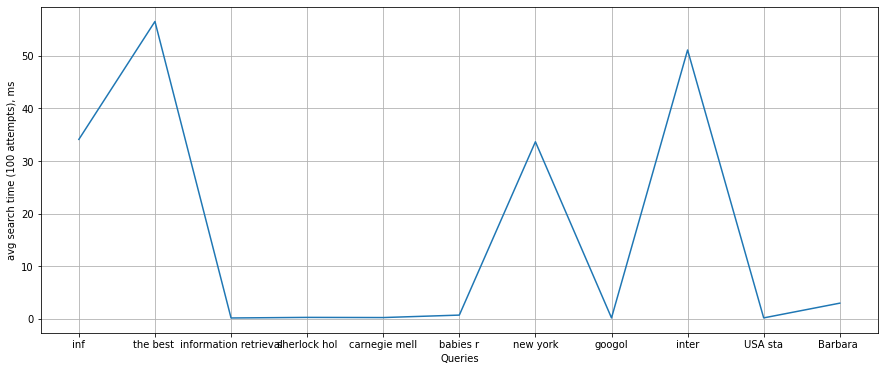

In [52]:
# Measure processing time
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
inp_queries = ["inf", "the best ", "information retrieval", "sherlock hol", "carnegie mell", 
               "babies r", "new york", "googol", "inter", "USA sta", "Barbara "]

search_times = []

for query in tqdm(inp_queries):
    iterations = 100
    duration = None
    query_time = []
    q = " ".join(prep.preprocess(query))
    # Measure the time of searching relevant queries
    for i in range(iterations):
        start = time.time()
        complete_user_query(query, aol_trie)
        finish = time.time()
        query_time.append(finish - start)
    search_times.append(np.average(query_time) * 1000)

# Time depends on query: it is super fast if not in trie,
# else it takes for me ~45 ms
print(f"Average over all queries={np.average(search_times):.3f} ms")
print("Plot of search time by each query")
fig = plt.figure(figsize=(15, 6))
plt.grid(True)
a = plt.axes()
a.set_xlabel('Queries')
a.set_ylabel('avg search time (100 attempts), ms')
plt.plot(inp_queries, search_times)
plt.show()


## 2.5. [+10/100] Bonus task - add spellchecking to your suggest

Try to make your search results as close as possible. Compare top-5 results of each query with top-5 results for corrected.

In [45]:
!pip install pyspellchecker

  Created wheel for autocorrect: filename=autocorrect-2.3.0-py3-none-any.whl size=621586 sha256=f405043fb6277cf1b20035ba48450396ab9773cd71af92324ce97c220edb7322
  Stored in directory: c:\users\demo8\appdata\local\pip\cache\wheels\51\64\a6\8078e9f7f871ced4819092c5799190bb149521c3921aeb2a5b
Successfully built autocorrect


In [53]:
from spellchecker import SpellChecker

spell = SpellChecker()

# I dropped "carnagie mell", because it is unfair test
inp_queries = ["inormation retrieval", "shelrock hol", "babis r", "Barrbara "]
inp_queries_corrected = ["information retrieval", "sherlock hol", "babies r", "Barbara "]

# The same function, but I correct each word by spell
def complete_user_query_with_spellchecker(query, trie, top_k=5):
    results = []
    q_prep = []
    # Stupid checking, if word is not a letter, because
    # SpellChecker could change it
    for word in prep.preprocess(query):
        if len(word) > 1:
            word = spell.correction(word)
        q_prep.append(word)
    # Now each word in a query is spell checked
    q_prep = " ".join(q_prep)
    if trie.has_subtrie(q_prep):
        for key, val in trie.iteritems(q_prep):
            results.append((key, val.freq, val.urls))
        results = sorted(results, key=lambda x:x[1], reverse=True)

    return results[:top_k]


for q, qc in zip(inp_queries, inp_queries_corrected):
    assert  complete_user_query(qc, aol_trie, 5) == \
            complete_user_query_with_spellchecker(q, aol_trie, 5),\
            "Assert {} and {} give different results".format(q, qc)